<a href="https://colab.research.google.com/github/trilgar/NN_2022/blob/master/NN_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image
import numpy as np
from torchvision import datasets
from tqdm import tqdm
import sys
from torchvision.transforms import RandAugment
from imgaug import augmenters as iaa

Встановлення сіду генератору

In [10]:
torch.manual_seed(10)

Завантаження датасету OxfordIIITPet

In [11]:
training_data = datasets.OxfordIIITPet(
    root="A:\datasets",
    download=True,
)

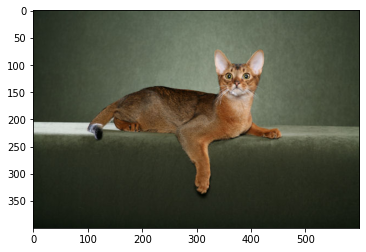

In [12]:
plt.imshow(plt.imread('/content/A:\datasets/oxford-iiit-pet/images/Abyssinian_1.jpg'))

In [13]:
filenames = glob('/content/A:\datasets/oxford-iiit-pet/images/*.jpg')

In [14]:
img = Image.open('/content/A:\datasets/oxford-iiit-pet/images/Abyssinian_1.jpg').convert('RGB')
img = np.array(img).astype(np.uint8)

In [15]:
rand_aug = iaa.RandAugment(n=3, m=7)

# Supervised learning model

In [16]:
class PetDataSet(Dataset):

    def __init__(self, filenames, class_to_label, transforms=None):
        self.filenames = filenames
        self.transforms = transforms
        self.class_to_label = class_to_label

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        # img = plt.imread(filename)
        # img = Image.fromarray(img).convert('RGB')
        img = Image.open(filename).convert('RGB')
        img = np.array(img).astype(np.uint8)

        if self.transforms is not None:
            img = self.transforms(img)
        label = self.get_label_from_filename(filename)
        return img ,label

    def get_label_from_filename(self, filename):
        clazz =  filename.rsplit('/', 1)[1].rsplit('_', 1)[0].replace('_', ' ').title()
        return self.class_to_label[clazz]

In [17]:
vgg_format = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

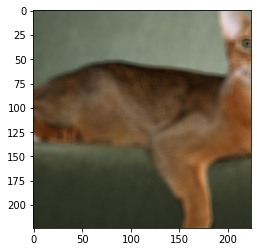

In [18]:
plt.imshow(vgg_format(rand_aug(images=[img])[0]).permute(1,2,0).numpy())

In [19]:
dataset=PetDataSet(filenames,training_data.class_to_idx,vgg_format)

train_ds_length = int(0.8 * len(dataset))
test_ds_length = int(0.2 * len(dataset))

train_ds, test_ds = torch.utils.data.random_split(dataset, [train_ds_length, test_ds_length])

train_dl = DataLoader(train_ds, batch_size=16)
test_dl = DataLoader(test_ds, batch_size=16)

Модель

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
load_from_existing = False

In [22]:
model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Linear(in_features=1000, out_features= number_of_labels, bias=True)
)
if load_from_existing:
    model.load_state_dict(torch.load('best_vgg.mdl'))
    print('loaded from previous save !!!')
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Навчання моделі

In [23]:
cross_el = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
epochs = 10

In [24]:
def evalute(model, loader):
    model.eval()

    correct = 0
    total = len(loader.dataset)
    val_bar = tqdm(loader, file=sys.stdout)
    for x, y in val_bar:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        x.cpu()
        y.cpu()
        correct += torch.eq(pred, y).sum().float().item()

    return correct / total

In [25]:
best_acc, best_epoch = 0, 0
losses = []
accuracy = []
for epoch in range(epochs):
    epoch_losses=0
    iters = 0
    model.train()
    train_bar = tqdm(train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses+=loss.item()
        iters+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss.item())
        x.cpu()
        y.cpu()
    losses.append(epoch_losses/iters)
    torch.cuda.empty_cache()
    if epoch % 1 == 0:  # You can change the validation frequency as you wish

        val_acc = evalute(model, test_dl)
        accuracy.append(val_acc)
        print('val_acc = ', val_acc)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_vgg.mdl')

100%|██████████| 93/93 [00:16<00:00,  5.56it/s]
val_acc =  0.8362652232746955
100%|██████████| 93/93 [00:16<00:00,  5.50it/s]
val_acc =  0.8538565629228687
100%|██████████| 93/93 [00:16<00:00,  5.74it/s]
val_acc =  0.8369418132611637
100%|██████████| 93/93 [00:16<00:00,  5.78it/s]
val_acc =  0.8585926928281461
100%|██████████| 93/93 [00:16<00:00,  5.78it/s]
val_acc =  0.8247631935047361
100%|██████████| 93/93 [00:16<00:00,  5.74it/s]
val_acc =  0.8606224627875507
100%|██████████| 93/93 [00:16<00:00,  5.76it/s]
val_acc =  0.86468200270636
100%|██████████| 93/93 [00:16<00:00,  5.49it/s]
val_acc =  0.851150202976996
100%|██████████| 93/93 [00:16<00:00,  5.64it/s]
val_acc =  0.8518267929634641
100%|██████████| 93/93 [00:16<00:00,  5.66it/s]
val_acc =  0.8694181326116374


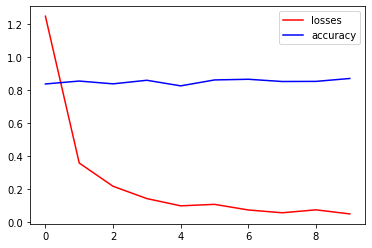

In [26]:
plt.plot(losses, label='losses',color='red')
plt.plot(accuracy, label= 'accuracy', color='blue')
plt.legend()
plt.show()

In [27]:
model.load_state_dict(torch.load('best_vgg.mdl'))
print('loaded from ckpt!')

test_acc = evalute(model, test_dl)
print('test acc:', test_acc)

loaded from ckpt!
100%|██████████| 93/93 [00:16<00:00,  5.64it/s]
test acc: 0.8694181326116374


# Noisy Student learning

Спочатку навчимо модель для розмітки нерозмічених даних

In [28]:
torch.cuda.empty_cache()
model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Linear(in_features=1000, out_features= number_of_labels, bias=True)
)
if load_from_existing:
    model.load_state_dict(torch.load('lab2_supervised.mdl'))
    print('loaded from previous save !!!')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [29]:
m_train_ds_length = int(0.3 * len(train_ds))
u_train_ds_length = int(0.7 * len(train_ds))

marked_train_ds, unmarked_train_ds = torch.utils.data.random_split(train_ds, [m_train_ds_length+1, u_train_ds_length])

marked_train_dl = DataLoader(marked_train_ds, batch_size=16)

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

Навчання моделі на розмічених даних

In [31]:
best_acc, best_epoch = 0, 0
losses_supervised = []
accuracy_supervised = []
for epoch in range(epochs):
    epoch_losses=0
    iters = 0
    model.train()
    train_bar = tqdm(marked_train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses+=loss.item()
        iters+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] (marked_dataset) loss:{:.3f}".format(epoch + 1, epochs, loss.item())
    losses_supervised.append(epoch_losses/iters)
    if epoch % 1 == 0:  # You can change the validation frequency as you wish

        val_acc = evalute(model, test_dl)
        accuracy_supervised.append(val_acc)
        print('val_acc = ', val_acc)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(), 'lab2_supervised.mdl')

100%|██████████| 93/93 [00:16<00:00,  5.58it/s]
val_acc =  0.6705006765899865
100%|██████████| 93/93 [00:16<00:00,  5.59it/s]
val_acc =  0.7584573748308525
100%|██████████| 93/93 [00:16<00:00,  5.62it/s]
val_acc =  0.7821380243572396
100%|██████████| 93/93 [00:16<00:00,  5.61it/s]
val_acc =  0.725981055480379
100%|██████████| 93/93 [00:16<00:00,  5.62it/s]
val_acc =  0.7855209742895806
100%|██████████| 93/93 [00:16<00:00,  5.58it/s]
val_acc =  0.7807848443843031
100%|██████████| 93/93 [00:16<00:00,  5.62it/s]
val_acc =  0.7638700947225981
100%|██████████| 93/93 [00:16<00:00,  5.63it/s]
val_acc =  0.8200270635994588
100%|██████████| 93/93 [00:16<00:00,  5.61it/s]
val_acc =  0.7401894451962111
100%|██████████| 93/93 [00:16<00:00,  5.60it/s]
val_acc =  0.7794316644113667


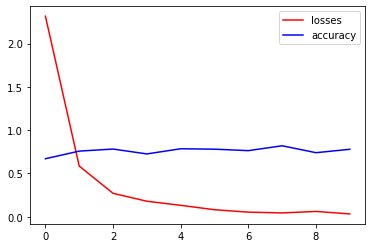

In [32]:
plt.plot(losses_supervised, label='losses',color='red')
plt.plot(accuracy_supervised, label= 'accuracy', color='blue')
plt.legend()
plt.show()

Навчання за допомогою NoisyStudent на повній вибірці (розмічені дані + псевдорозмічені)

In [33]:
class PseudoLabeledPetDataSet(PetDataSet):

    def __init__(self, filenames, model = None, augment = None, transforms=None):
        super(PseudoLabeledPetDataSet, self).__init__(filenames, None, transforms=transforms)
        self.augment = augment
        self.model = model
        if self.model is not None:
            self.pseudolabels = self.calculate_pseudolabels()

    @staticmethod
    def from_ss(ds: Subset, model, augment=None, transforms = None):
        return PseudoLabeledPetDataSet(ds.dataset.dataset.filenames, model, augment = augment, transforms = transforms)

    def __getitem__(self, i):
        filename = self.filenames[i]
        img = Image.open(filename).convert('RGB')
        img = np.array(img).astype(np.uint8)
        if self.augment is not None:
            img = self.augment(images=[img])
            img = np.array(img[0]).astype(np.uint8)
        if self.transforms is not None:
            img = self.transforms(img)
        label = self.get_label_from_filename(filename)
        return img ,label

    def calculate_pseudolabels(self):
        pseudolabels = {}
        self.model.eval()
        filenames = self.filenames
        for filename in tqdm(filenames):
            img = Image.open(filename).convert('RGB')
            img = np.array(img).astype(np.uint8)
            if self.transforms is not None:
                img = self.transforms(img)
            logit = self.model(img.to(device).unsqueeze(0))
            predict = logit.argmax(dim=1)
            pseudolabels[filename] = predict.item()
        return pseudolabels

    def get_label_from_filename(self, filename):
        if self.model is not None:
            return self.pseudolabels[filename]
        else:
            return PetDataSet.get_label_from_filename(self, filename)

In [34]:
# _marked_train_ds = PseudoLabeledPetDataSet.from_ss(marked_train_ds, None, augment=RandAugment(), transforms=vgg_format)
# marked_train_dl = DataLoader(_marked_train_ds, batch_size=16)
rand_aug = iaa.RandAugment(n=2, m=9)
_unmarked_train_ds = PseudoLabeledPetDataSet.from_ss(unmarked_train_ds, model, augment=rand_aug, transforms=vgg_format)
unmarked_train_dl = DataLoader(_unmarked_train_ds, batch_size=8)

marked_train_dl = DataLoader(marked_train_ds, batch_size=8)

100%|██████████| 7390/7390 [01:53<00:00, 65.18it/s]


In [35]:
torch.cuda.empty_cache()

model = torchvision.models.vgg19(pretrained=True)

number_of_labels = len(training_data.classes)
model.classifier = torch.nn.Sequential(
    model.classifier,
    torch.nn.Dropout(0.25),
    torch.nn.Linear(in_features=1000, out_features= number_of_labels, bias=True)
)
if load_from_existing:
    model.load_state_dict(torch.load('lab2_semisupervised.mdl'))
    print('loaded from previous save !!!')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [37]:
torch.cuda.empty_cache()

In [38]:
best_acc, best_epoch = 0, 0
losses_semisupervised = []
accuracy_semisupervised = []
for epoch in range(epochs):
    epoch_losses=0
    iters = 0
    model.train()
    train_bar = tqdm(unmarked_train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses+=loss.item()
        iters+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] (unmarked_dataset) loss:{:.3f}".format(epoch + 1, epochs, loss.item())
    train_bar = tqdm(marked_train_dl, file=sys.stdout)
    for data in train_bar:
        x, y = data
        output = model(x.to(device))
        loss = cross_el(output, y.to(device))
        epoch_losses+=loss.item()
        iters+=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_bar.desc = "train epoch[{}/{}] (marked_dataset) loss:{:.3f}".format(epoch + 1, epochs, loss.item())

    losses_semisupervised.append(epoch_losses/iters)
    if epoch % 1 == 0:  # You can change the validation frequency as you wish

        val_acc = evalute(model, test_dl)
        accuracy_semisupervised.append(val_acc)
        print('val_acc = ', val_acc)
        if val_acc > best_acc:
            best_epoch = epoch
            best_acc = val_acc
            torch.save(model.state_dict(), 'lab2_semisupervised.mdl')

100%|██████████| 93/93 [00:17<00:00,  5.38it/s]
val_acc =  0.8376184032476319
100%|██████████| 93/93 [00:16<00:00,  5.58it/s]
val_acc =  0.8274695534506089
100%|██████████| 93/93 [00:16<00:00,  5.57it/s]
val_acc =  0.8213802435723951
100%|██████████| 93/93 [00:17<00:00,  5.44it/s]
val_acc =  0.8044654939106901
100%|██████████| 93/93 [00:16<00:00,  5.59it/s]
val_acc =  0.8125845737483085
100%|██████████| 93/93 [00:17<00:00,  5.44it/s]
val_acc =  0.8227334235453315
100%|██████████| 93/93 [00:16<00:00,  5.56it/s]
val_acc =  0.8159675236806495
100%|██████████| 93/93 [00:17<00:00,  5.35it/s]
val_acc =  0.8044654939106901
100%|██████████| 93/93 [00:17<00:00,  5.30it/s]
val_acc =  0.8010825439783491
100%|██████████| 93/93 [00:16<00:00,  5.52it/s]
val_acc =  0.8092016238159675


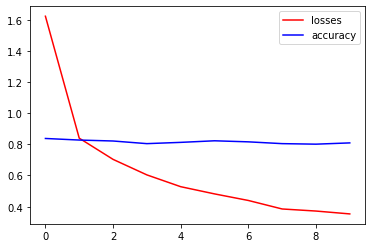

In [39]:
plt.plot(losses_semisupervised, label='losses',color='red')
plt.plot(accuracy_semisupervised, label= 'accuracy', color='blue')
plt.legend()
plt.show()

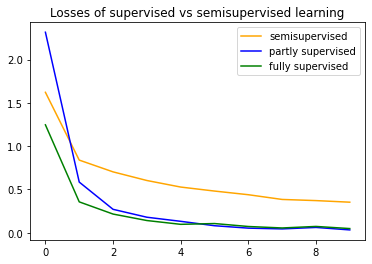

In [40]:
plt.plot(losses_semisupervised, label='semisupervised',color='orange')
plt.plot(losses_supervised, label='partly supervised', color='blue')
plt.plot(losses, label='fully supervised',color='green')
plt.title('Losses of supervised vs semisupervised learning')
plt.legend()
plt.show()

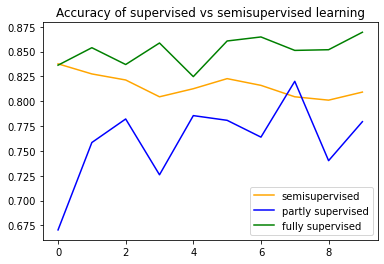

In [42]:
plt.plot(accuracy_semisupervised, label='semisupervised',color='orange')
plt.plot(accuracy_supervised, label='partly supervised',color='blue')
plt.plot(accuracy, label='fully supervised',color='green')
plt.title('Accuracy of supervised vs semisupervised learning')
plt.legend()
plt.show()